In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
import string
from nltk.corpus import stopwords
import gensim
from gensim import parsing
from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [59]:
train= pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [60]:
test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [61]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [63]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [64]:
train.drop(['keyword', 'location'],axis=1, inplace=True)

In [66]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

**Data Visualization**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of disaster and non disaster tweets')

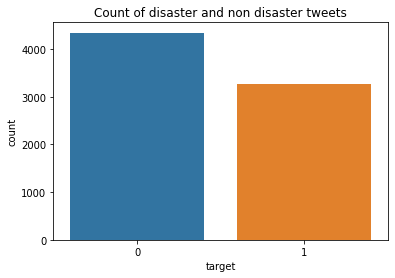

In [67]:
plot=sns.countplot(train['target'])
plot.set_title("Count of disaster and non disaster tweets")

The dataset is balanced.

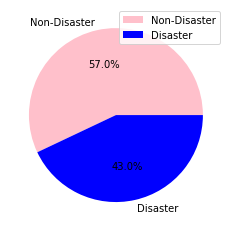

In [68]:
mylabels=["Non-Disaster", "Disaster"]
mycolors=['pink', 'blue']
plt.pie(train['target'].value_counts(), labels=mylabels, colors=mycolors,autopct='%1.1f%%')
plt.legend()
plt.show()

**WordCloud for Disaster Tweets**

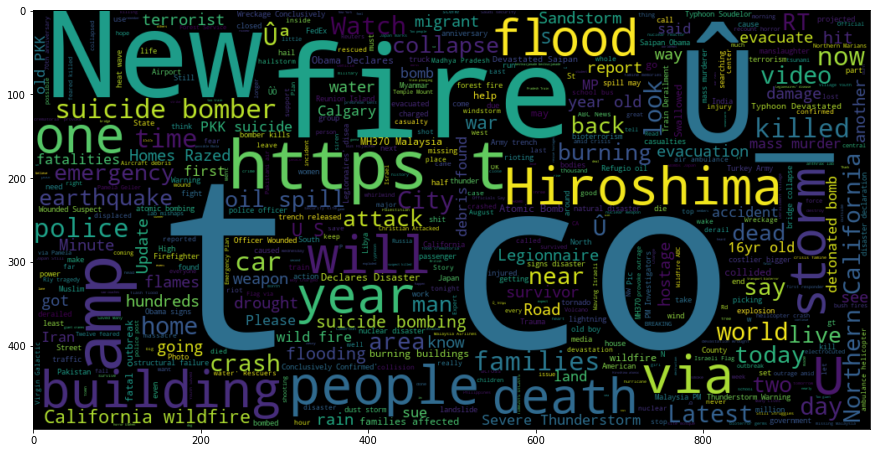

In [69]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(train[train.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

**WordCloud for Non-Disaster Tweets**

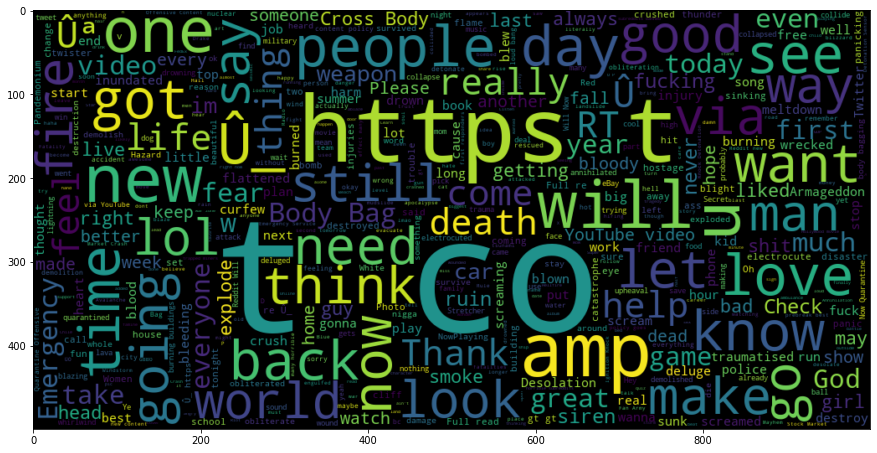

In [70]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(train[train.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Data Preprocessing**

In [71]:
def transformText(text):
  # All the necessary preprocessing on our text of choice
    stops = set(stopwords.words("english"))
  # Convert text to lower
    text = text.lower()
  # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text) 
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub('http','',text)
    text= gensim.parsing.preprocessing.strip_non_alphanum(text)                       
  # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
  # Removing all the stopwords
    filtered_words = [word for word in text.split() if word not in stops]
  # Removing all the tokens with lesser than 3 characters
    filtered_words = gensim.corpora.textcorpus.remove_short(filtered_words, minsize=3)
  # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
  # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
  # Strip all the numerics
    text = gensim.parsing.preprocessing.strip_numeric(text)
  # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
  # Stemming
    return gensim.parsing.preprocessing.stem_text(text)

In [72]:
train['text']=train['text'].apply(transformText)

In [73]:
train.head(10)

,id,text,target
0,1,deed reason earthquak mai allah forgiv,1
1,4,forest fire near rong sask canada,1
2,5,resid ask shelter place notifi offic evacu she...,1
3,6,peopl receiv wildfir evacu order california,1
4,7,got sent photo rubi alaska smoke wildfir pour ...,1
5,8,rockyfir updat california hwy close direct due...,1
6,10,flood disast heavi rain caus flash flood stree...,1
7,13,top hill see fire wood,1
8,14,emerg evacu happen build across street,1
9,15,afraid tornado come area,1


**N-Gram Analysis**

In [74]:
texts=''.join(train['text'])
words=texts.split(" ")

In [75]:
def draw_n_gram(words,i):
    n_gram=(pd.Series(nltk.ngrams(words,i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df=n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)


**Unigram Analysis**

      word  count
0  (like,)    340
1   (amp,)    339
2  (fire,)    312
3   (new,)    294
4   (get,)    283


<AxesSubplot:xlabel='count', ylabel='word'>

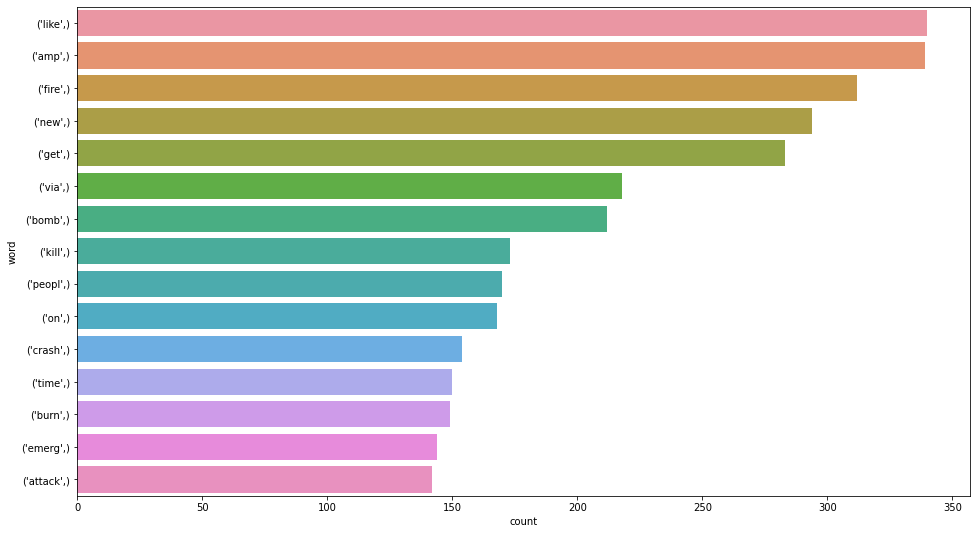

In [76]:
draw_n_gram(words,1)

**Bi-gram Analysis**

             word  count
0     (bodi, bag)     61
1  (mass, murder)     53
2   (burn, build)     51
3    (atom, bomb)     49
4    (look, like)     45


<AxesSubplot:xlabel='count', ylabel='word'>

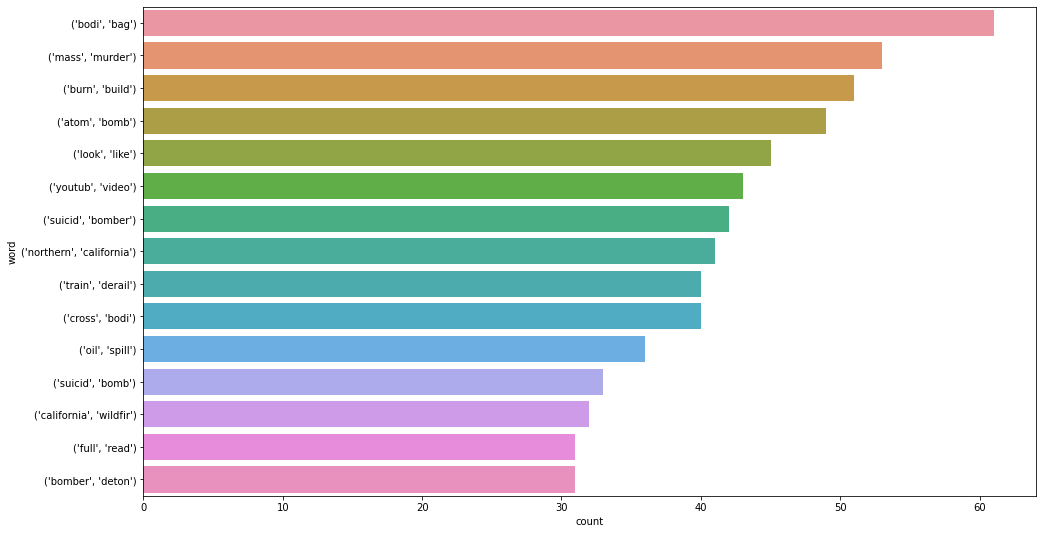

In [77]:
draw_n_gram(words,2)

**Tri-gram Analysis**

                              word  count
0          (suicid, bomber, deton)     30
1  (northern, california, wildfir)     29
2            (bomber, deton, bomb)     28
3            (pkk, suicid, bomber)     28
4     (raze, northern, california)     27


<AxesSubplot:xlabel='count', ylabel='word'>

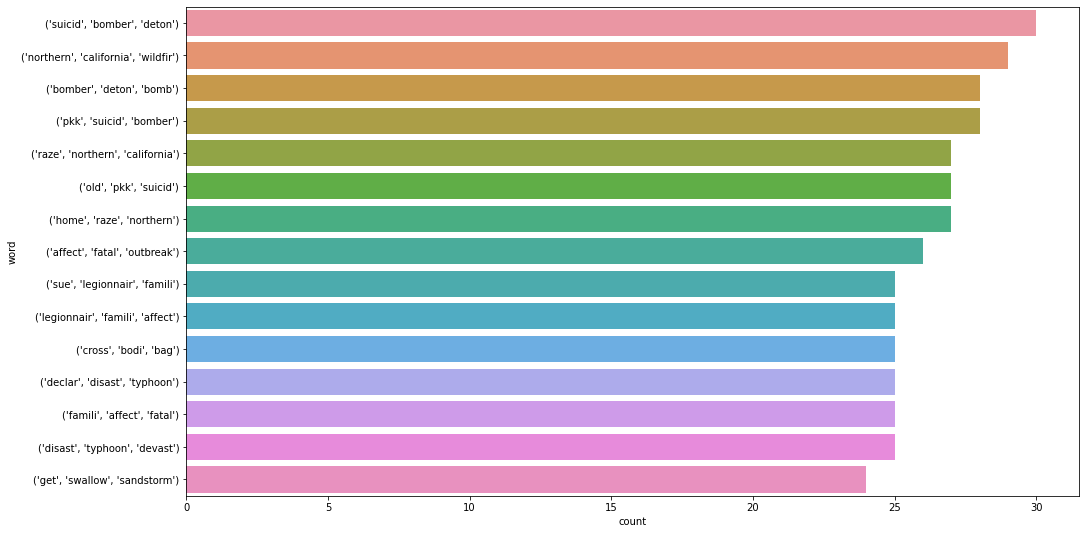

In [78]:
draw_n_gram(words,3)

In [85]:
X=train['text']
y=train['target']

**Splitting data into train and test set**

In [87]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30, random_state=1)

In [88]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5329,)
(2284,)
(5329,)
(2284,)


# Feature Extraction with Count Vectorizer and TfidfTransformer(Term Frequency-Inverse Document Frequency)

In [91]:
vectorizer=CountVectorizer()
transformer=TfidfTransformer()

**For train data**

In [93]:
X_train_vect=vectorizer.fit_transform(X_train)
X_train_trans=transformer.fit_transform(X_train_vect)

In [100]:
X_train_trans.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**For test data**

In [94]:
X_test_vect=vectorizer.transform(X_test)
X_test_trans=transformer.transform(X_test_vect)

In [101]:
X_test_trans.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Building Model 

In [97]:
lr=LogisticRegression()
dtc= DecisionTreeClassifier()
rfc= RandomForestClassifier()
svm= SVC()
knn= KNeighborsClassifier()
nb= GaussianNB()

In [103]:
lr.fit(X_train_trans,y_train)
dtc.fit(X_train_trans,y_train)
rfc.fit(X_train_trans ,y_train)
svm.fit(X_train_trans ,y_train)
knn.fit(X_train_trans ,y_train)
#nb.fit(X_train_trans ,y_train)

KNeighborsClassifier()

**Making Predictions**

In [105]:
predict_lr = lr.predict(X_test_trans)
predict_dtc = dtc.predict(X_test_trans)
predict_rfc = rfc.predict(X_test_trans)
predict_svm = svm.predict(X_test_trans)
predict_knn = knn.predict(X_test_trans)

**Checking model performance**

In [121]:
acc_1=accuracy_score(predict_lr,y_test)
print("Accuracy of LogisticRegression = " +str(acc_1))
acc_2=accuracy_score(predict_dtc,y_test)
print("Accuracy of DecisionTreeClassifier = " +str(acc_2))
acc_3 =  accuracy_score(predict_rfc,y_test)
print("Accuracy of RandomForestClassifier = " +str(acc_3))
acc_4 = accuracy_score(predict_svm,y_test)
print("Accuracy of SupportVectorClassifier = " +str(acc_4))
acc_5 = accuracy_score(predict_knn,y_test)
print("Accuracy of KNearestNeighbor = " +str(acc_5))

Accuracy of LogisticRegression = 0.8007880910683012
Accuracy of DecisionTreeClassifier = 0.7254816112084063
Accuracy of RandomForestClassifier = 0.7946584938704028
Accuracy of SupportVectorClassifier = 0.8047285464098074
Accuracy of KNearestNeighbor = 0.7631348511383538


**Here, we see that SupportVectorClassifier gives the best accuracy score of 80.47%**

**Now, we predict for test data using SVC**

In [124]:
X_test=test['text']
X_test.head()

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object

In [125]:
X_test_vec=vectorizer.transform(X_test)
X_test_tran=transformer.transform(X_test_vec)

In [127]:
X_test_tran.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [129]:
predictions= svm.predict(X_test_tran)
predictions

array([1, 0, 1, ..., 1, 1, 0])

In [130]:
submission = pd.DataFrame()

In [132]:
submission['id']= test['id']
submission['target']= predictions

In [133]:
submission['target'].value_counts()

0    2423
1     840
Name: target, dtype: int64

In [136]:
submission.to_csv('solution.csv', index=False)